## Fit PDF


In [1]:
# load csv
import pandas as pd

df = pd.read_csv('../customer_support_tickets.csv')

In [2]:
# drop first response time Null/Nan and Time to resolution NaN/Null
df.dropna(inplace=True)

df['First Response Time'] = df['First Response Time'].apply(lambda x: x.replace(' ', 'T').strip())
df['Time to Resolution'] = df['Time to Resolution'].apply(lambda x: x.replace(' ', 'T').strip())


In [3]:
# convert to datetime
df['First Response Time'] = pd.to_datetime(df['First Response Time'])
df['Time to Resolution'] = pd.to_datetime(df['Time to Resolution'])

In [4]:
# remove where 'First Response Time' is greater or equal than 'Time to Resolution'
df = df[df['First Response Time'] < df['Time to Resolution']]

In [5]:
df.head()

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0
19,20,Jeffrey Robertson,jameslopez@example.com,39,Female,Canon EOS,2021-03-08,Refund request,Software bug,I'm having an issue with the {product_purchase...,Closed,Wish mouth build resource though.,Low,Chat,2023-06-01 00:46:04,2023-06-01 20:29:04,5.0
28,29,Christine Wang,garciastacy@example.com,30,Other,Fitbit Charge,2020-06-10,Technical issue,Product recommendation,I'm having an issue with the {product_purchase...,Closed,Soldier we such inside.,Critical,Phone,2023-05-31 23:17:17,2023-06-01 06:03:17,5.0
29,30,Austin George,shericase@example.net,67,Male,Xbox,2020-12-26,Cancellation request,Cancellation request,I'm having an issue with the {product_purchase...,Closed,Firm sort voice above which site arrive.,Medium,Phone,2023-06-01 00:54:17,2023-06-01 18:23:17,1.0


In [23]:
data = pd.DataFrame()
data['First Response Time'] = df['First Response Time']
# we only care about the minutes
data.sort_values(by='First Response Time', inplace=True)
data['ia_minutes'] = data['First Response Time'].apply(lambda x: x.hour * 60 + x.minute)
data['time_diff_minutes'] = data['First Response Time'].diff().dt.total_seconds()
data['time_diff_minutes'] = data['time_diff_minutes'].fillna(0)
data.head()

,First Response Time,ia_minutes,time_diff_minutes
395,2023-05-31 21:55:39,1315,0.0
765,2023-05-31 22:06:18,1326,639.0
128,2023-05-31 22:12:33,1332,375.0
371,2023-05-31 22:20:05,1340,452.0
418,2023-05-31 22:20:10,1340,5.0


In [24]:
data['time_diff_minutes'].describe()

count    1402.000000
mean       66.002140
std       124.981892
min         0.000000
25%        14.000000
50%        37.000000
75%        79.000000
max      3165.000000
Name: time_diff_minutes, dtype: float64

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
truncpareto,6.438139e-07,2731.328914,2752.311534,inf,0.019438,0.657161
pareto,6.441166e-07,2729.334209,2745.071174,inf,0.019432,0.657506
wald,1.028937e-06,3999.969041,4010.460352,inf,0.051988,0.000985
powerlognorm,1.080702e-06,2922.554934,2943.537554,inf,0.023271,0.427065
genhyperbolic,1.712702e-06,7568.936964,7595.165239,inf,0.049645,0.001924


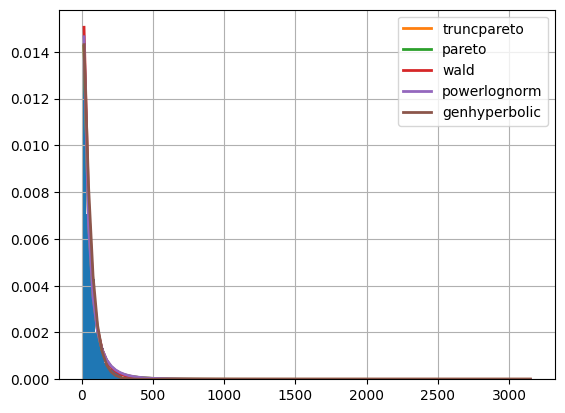

In [25]:
from fitter import Fitter

f = Fitter(data['time_diff_minutes'])
f.fit()
# may take some time since by default, all distributions are tried,
# but you call manually provide a smaller set of distributions
f.summary()

In [26]:
best_params_arrivals = f.get_best(method='sumsquare_error')
print(best_params_arrivals)

{'truncpareto': {'b': 3.4730237348159223, 'c': 20.79360641835896, 'loc': -159.90011790193023, 'scale': 159.9001179019302}}


In [27]:
from scipy import stats

ia = stats.truncpareto.rvs(**best_params_arrivals.get('truncpareto'), size=4_000)

gen = pd.DataFrame()
gen['ia'] = ia

In [11]:
gen.head()

,ia
0,1.188578
1,2.005288
2,1.739954
3,0.048959
4,1.707396


In [28]:
gen['ia'].describe()

count    4000.000000
mean       67.184765
std        97.612213
min         0.015649
25%        14.723132
50%        36.245727
75%        81.138452
max      1520.114491
Name: ia, dtype: float64

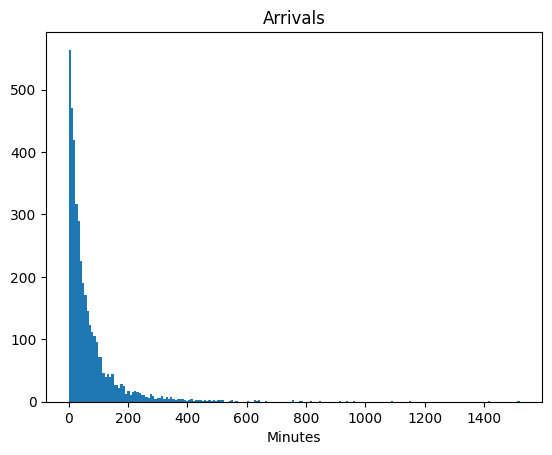

In [29]:
import matplotlib.pyplot as plt

plt.title('Arrivals')
plt.xlabel('Minutes')
plt.hist(gen['ia'], bins=200)
plt.show()

In [31]:
# same for resolution time
data = pd.DataFrame()
data['Time to Resolution'] = df['Time to Resolution']
data['First Response Time'] = df['First Response Time']
data['delta'] = data['Time to Resolution'] - data['First Response Time']
data['ta_minutes'] = data['delta'].apply(lambda x: x.total_seconds() / 60)

In [32]:
data['ta_minutes'].head()

2      411.0
4     1181.0
19    1183.0
28     406.0
29    1049.0
Name: ta_minutes, dtype: float64

In [33]:
data['ta_minutes'].describe()

count    1402.000000
mean      455.324536
std       335.597811
min         1.000000
25%       180.000000
50%       382.500000
75%       681.750000
max      1408.000000
Name: ta_minutes, dtype: float64

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gausshyper,0.000003,1516.447518,1547.921449,inf,0.015985,0.860431
genpareto,0.000004,1514.700057,1530.437022,inf,0.028109,0.213883
beta,0.000004,1516.943784,1537.926405,inf,0.024999,0.339338
halfnorm,0.000004,1523.322238,1533.813549,inf,0.028099,0.214216
skewnorm,0.000004,1525.227381,1540.964346,inf,0.028174,0.211693


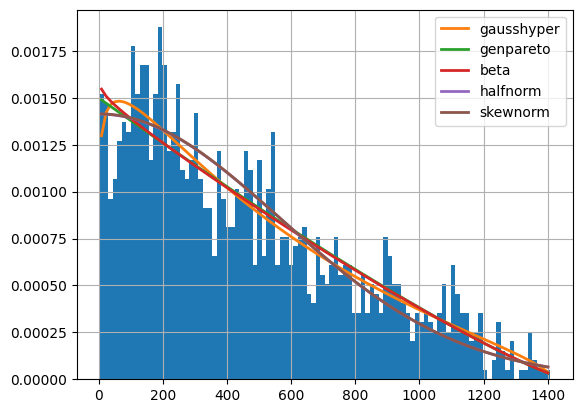

In [34]:
f = Fitter(data['ta_minutes'])
f.fit()
f.summary()

In [35]:
# The best fit is the gausshyper distribution, but we can also try the argus distribution
best_params_arrivals = f.get_best(method='sumsquare_error')
print(best_params_arrivals)

{'gausshyper': {'a': 1.1056018226255544, 'b': 1.6205702068080348, 'c': 2.143556917168204, 'z': 0.8747466122834441, 'loc': 0.9255225356041091, 'scale': 1415.6772955915094}}


In [38]:
ta = stats.gausshyper.rvs(**best_params_arrivals.get('gausshyper'), size=4_000)
gen['ta'] = ta

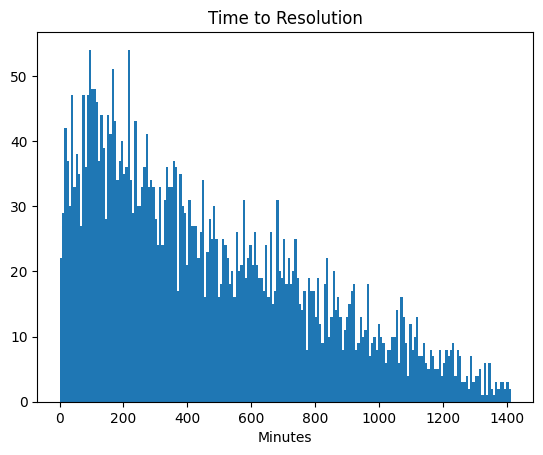

In [39]:
plt.title('Time to Resolution')
plt.xlabel('Minutes')
plt.hist(gen['ta'], bins=200)
plt.show()